In [1]:
import sys
from pathlib import Path
import os
import h5py

import torch
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/")
sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/Dietnet")
from Dietnet.make_attributions import load_data, load_model
from Dietnet.helpers import dataset_utils as du
from Dietnet.Interpretability import graph_attribution_manager as gam

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"
device = torch.device('cuda:0')

##  Create Attribution Manager

In [2]:
which_fold = 0
seed = 23
train_valid_ratio = 0.75

exp_path = Path('/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/Dietnet2/1000G_EXP/EXP01_2020.07')
exp_folder = 'REPRODUCE_2020.07'
full_path = exp_path / exp_folder / '{}_fold{}'.format(exp_folder, which_fold)
model_path =  full_path / 'model_params.pt'

dataset = 'dataset.npz'
embedding = 'embedding.npz'
folds_indexes = 'folds_indexes.npz'

#  Get data
test_generator, x_test = load_data(exp_path, dataset, folds_indexes, which_fold, seed, train_valid_ratio, device, batch_size=12)


#  Load embedding
emb = du.load_embedding(os.path.join(exp_path, embedding), which_fold)
emb = emb.to(device)
emb = emb.float()

#  Normalize embedding
emb_norm = (emb ** 2).sum(0) ** 0.5
emb = emb/emb_norm

#  Instantiate model
n_feats_emb = emb.size()[1] # input of aux net
n_feats = emb.size()[0] # input of main net

#  Hidden layers size
n_hidden_u = 100
n_hidden1_u = 100
n_hidden2_u = 100

#  Output layer
n_targets = test_generator.dataset.ys.max().item()+1
input_dropout = 0.

In [3]:
#  attrs file created in make_attributions.ipynb
attr_manager = gam.GraphAttributionManager()
attr_manager.set_device(device)

hf = h5py.File(os.path.join(full_path, 'attrs_avg_true_0.h5'), 'r')
attr_manager.set_agg_attributions(hf['avg_attr'][:, :, :])
attr_manager.set_feat_names(np.load(os.path.join(full_path, 'additional_data.npz'))['feature_names'])
attr_manager.set_label_names(np.load(os.path.join(full_path, 'additional_data.npz'))['label_names'])
attr_manager.set_labels(torch.from_numpy(np.load(os.path.join(full_path, 'additional_data.npz'))['test_labels']))
attr_manager.set_genotypes_data(x_test)
attr_manager.set_data_generator(test_generator)

#  Initialize Attribution method
#attr_manager.init_attribution_function(attr_type='int_grad', backend='captum')

#  Initialize Model
#disc_net = load_model(model_path, emb, device, n_feats_emb, n_hidden_u, n_hidden1_u,  n_hidden2_u, n_targets, input_dropout, incl_bias=True, incl_softmax=True)
#attr_manager.set_model(disc_net)

attr_manager.set_working_dir('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments')

assert attr_manager.graph_mode # ensure we have everything we need to make graphs!

## Plot (Global) Attributions

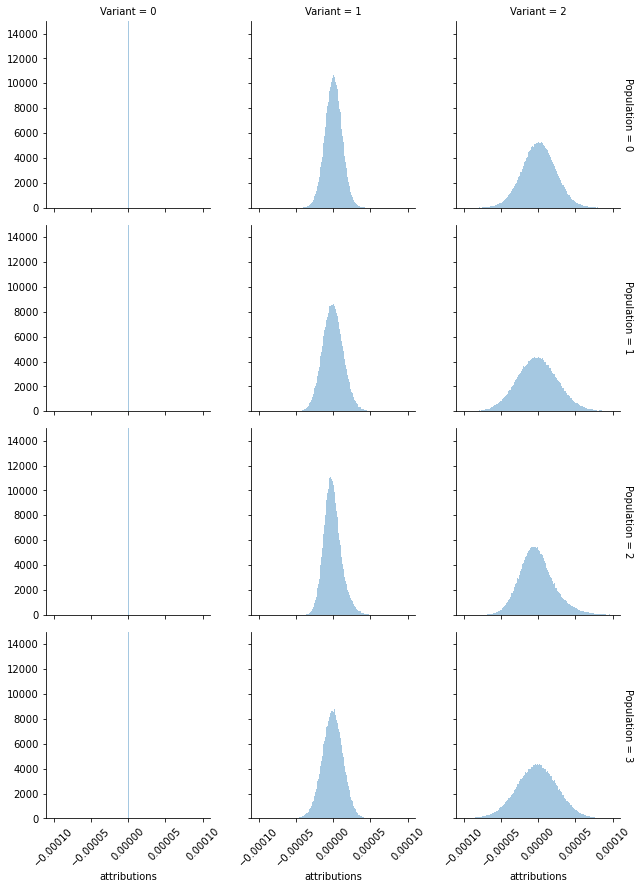

In [4]:
attr_manager.plot_attr_histograms(plot_options={'ylim': (0, 15000)}, 
                                  scatter_options={'bins': np.arange(-1e-4, 1e-4, 1e-6), 'kde': False},
                                  pops_to_view=[0, 1, 2, 3])

##  Plot (Local) Attributions

In [5]:
attr_manager.set_raw_attributions_file(os.path.join(full_path, 'attrs_true_0.h5'))

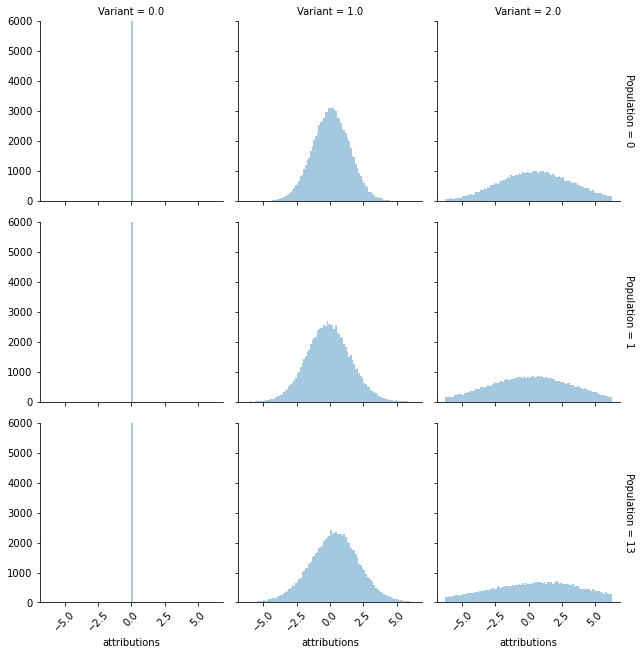

In [6]:
#  See how attributions are different for true target vs. others
attr_manager.plot_attr_individuals(plot_options={'ylim': (0, 6000)}, 
                                   scatter_options={'bins': np.arange(-5e-5, 5e-5, 1e-6), 'kde': False},
                                   indv_to_view=[0],
                                   pops_to_view=[attr_manager.labels[0].item(), 1, 0])

In [7]:
import h5py

with h5py.File(attr_manager.raw_attributions_file, 'r') as hf:
    attr_manager.attr_type = list(hf.keys())[0]
    to_view = hf[attr_manager.attr_type][0]
    
print('(for indv 0) avg attr correct class: {:.2E}'.format(to_view[:,13].mean()))
print('(for indv 0) avg attr incorrect class: {:.2E}'.format(to_view[:,np.concatenate([np.arange(0,13), np.arange(14,26)])].mean()))

(for indv 0) avg attr correct class: 2.37E-06
(for indv 0) avg attr incorrect class: -5.21E-07


In [45]:
with h5py.File(attr_manager.raw_attributions_file, 'r') as hf:
    attr_manager.attr_type = list(hf.keys())[0]
    true_attrs = np.concatenate([hf[attr_manager.attr_type][i, :, label].reshape(1, -1) for i,label in enumerate(attr_manager.labels.numpy())])
    other_attrs = np.concatenate([hf[attr_manager.attr_type][i, 
                                                             :, 
                                                             np.concatenate([np.arange(0,label), np.arange(label+1,26)])
                                                            ].reshape(1, -1) for i,label in enumerate(attr_manager.labels.numpy())])

In [49]:
# ignore 0's
true_attrs = true_attrs[true_attrs!=0]
other_attrs = other_attrs[other_attrs!=0]
print('(for all indvs) avg attr correct class: {:.2E} +/- {:.2E}'.format(true_attrs.mean(), true_attrs.std()))
print('(for all indvs) avg attr incorrect class: {:.2E} +/- {:.2E}'.format(other_attrs.mean(), other_attrs.std()))

(for all indvs) avg attr correct class: 6.54E-07 +/- 2.33E-05
(for all indvs) avg attr incorrect class: -8.96E-07 +/- 2.13E-05


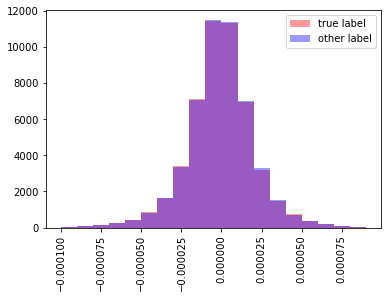

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
color = ['r', 'b']
label = ['true label', 'other label']
for i, a in enumerate([true_attrs, other_attrs]):
    sns.distplot(other_attrs[np.random.choice(np.arange(a.shape[0]), size=50000)], bins=np.arange(-1e-4, 1e-4, 1e-5), ax=ax, kde=False, color=color[i], label=label[i])
plt.xticks(rotation=90)
plt.legend()

##  Make Plots

In [ ]:
attr_manager.plot_attr_vs_allele_freq(save_path='/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments/attr_vs_per_pop_allele_freq_baselin0_show_outliers.png',
                                      global_metric=False,
                                      scatter_options={'s': 2, 'alpha': 1}, # 2, 0.03
                                      plot_options={'height': 5}) #'xlim': (20*-5.3e-6, 20*5.3e-6)

In [ ]:
attr_manager.plot_attr_vs_gene_freq(save_path='/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments/attr_vs_per_pop_genotype_freq_baseline0_show_outliers.png',
                                    global_metric=False,
                                    scatter_options={'s': 2, 'alpha': 1}, # 2, 0.03
                                    plot_options={'height': 5})

##  FST values

In [ ]:
import pandas as pd

fsts = pd.read_csv('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/dietnet/FST_ALL/AFR_EUR.weir.fst', sep='\t') # doesnt make sense since we have 26 pops and not just EUR vs AFR
fsts = fsts.drop(columns=['CHROM', 'POS'])

In [ ]:
for var in [0,1,2]:
    fsts['Variant'] = var
    fsts['Population'] = 1
    fsts['SNP'] = fsts.index.values

    attr_manager.plot_attr_vs_snp_score(fsts, "WEIR_AND_COCKERHAM_FST", 
                                        save_path='test_pic', 
                                        scatter_options={'s': 2, 'alpha': 0.01}, 
                                        plot_options={'xlim': (-1e-4, 1e-4), 'height': 5})
    plt.xticks(rotation=90)